<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Task 1
</p>

- Author: Anatoly Medvedev
- Group: J4322c

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Сontents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Dataset</a></li>
        <li><a href="#002">Multi-step LSTM Prediction Model</a></li>
        <li><a href="#003">ARIMA Prediction Model</a></li>
        <li><a href="#004">Conclusion</a></li>
    </ol>
</div>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import datetime
import warnings

import tensorflow as tf
import statsmodels.api as sm
from keras import backend as K
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

warnings.filterwarnings(action="ignore")
sns.set_style("whitegrid")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Dataset
        </p>
    </a>
</blockquote>

Dataset: Microsoft Stock Data between 2015 and 2022 in USD

Link: https://www.kaggle.com/datasets/berkayalan/microsoft-stock-data-between-2015-and-2022

In [2]:
data = pd.read_csv("microsoft_stocks.csv", parse_dates=["date"])
data.head()

,date,close
0,2015-01-12,46.599998
1,2015-01-13,46.360001
2,2015-01-14,45.959999
3,2015-01-15,45.480000
4,2015-01-16,46.240002


In [3]:
data.describe()

,close
count,1701.000000
mean,118.551152
std,71.386184
min,40.290001
25%,57.660000
50%,98.029999
75%,160.229996
max,305.220001


<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Multi-step LSTM Prediction Model
        </p>
    </a>
</blockquote>

In [4]:
# Trajectory matrix for solving supervized learning task.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Incoming sequence (t-n, ... t-1).
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j+1, i)) for j in range(n_vars)]
    # Predicted sequence (t, t+1, ... t+n).
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j+1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


# Diffential series interval.
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    return pd.Series(diff)


# Train/test splitting.
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    
    return scaler, train, test


# RSquare metric.
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (1 - SS_res/(SS_tot + K.epsilon()))


# Fit LSTM network.
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # Reshape training into [samples, timesteps, features].
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=[
        tf.keras.metrics.mean_absolute_percentage_error,
        coeff_determination
    ])
    history_loss = []
    history_val_loss = []
    
    for epoch in range(nb_epoch):
        print("Epoch:", epoch+1)
        hist = model.fit(X, y, validation_split=0.1, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history["loss"])
        history_val_loss.append(hist.history["val_loss"])
    
    print(model.summary())
    
    return model, history_loss, history_val_loss


# 1 step of forecasting.
def forecast_lstm(model, X, n_batch):
    # Reshape input pattern to [samples, timesteps, features].
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    
    return [x for x in forecast[0, :]]


# Forecasting.
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    
    return forecasts

# Inverse Difference.
def inverse_difference(last_ob, forecast):
    # Invert first forecast.
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate difference forecast using inverted first value.
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    
    return inverted
 
# Inverse transformation.
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # Create array from forecast.
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # Invert scaling.
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # Invert differencing.
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    
    return inverted

In [5]:
data = pd.read_csv("microsoft_stocks.csv", index_col=["date"], parse_dates=["date"], encoding="cp1251")
print("Number of rows:", len(data))
data.head()

Number of rows: 1701


,close
date,
2015-01-12,46.599998
2015-01-13,46.360001
2015-01-14,45.959999
2015-01-15,45.480000
2015-01-16,46.240002


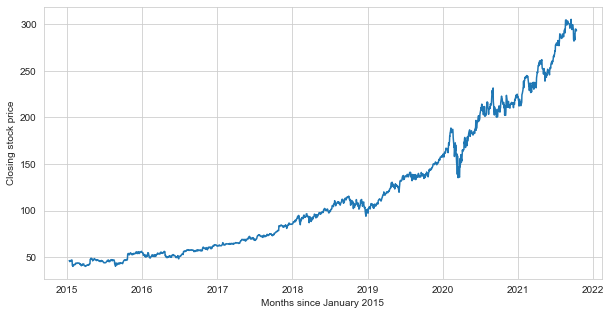

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(data)
plt.ylabel("Closing stock price")
plt.xlabel("Months since January 2015")
plt.show()

In [7]:
# Trajectory matrix.
d1 = series_to_supervised(data, n_in=5, n_out=7, dropnan=True)
d1.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
date,,,,,,,,,,,,
2015-01-20,46.599998,46.360001,45.959999,45.480000,46.240002,46.389999,45.919998,47.130001,47.180000,47.009998,42.660000,41.189999
2015-01-21,46.360001,45.959999,45.480000,46.240002,46.389999,45.919998,47.130001,47.180000,47.009998,42.660000,41.189999,42.009998
2015-01-22,45.959999,45.480000,46.240002,46.389999,45.919998,47.130001,47.180000,47.009998,42.660000,41.189999,42.009998,40.400002
2015-01-23,45.480000,46.240002,46.389999,45.919998,47.130001,47.180000,47.009998,42.660000,41.189999,42.009998,40.400002,41.279999
2015-01-26,46.240002,46.389999,45.919998,47.130001,47.180000,47.009998,42.660000,41.189999,42.009998,40.400002,41.279999,41.599998


In [8]:
# Hyperparameters initialization and training the model.
n_lag = int(len(data)/5)
n_seq = int(len(data)/5)
n_test = int(len(data)/8)
n_epochs = 30
n_batch = 1
n_neurons = 256

scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(data, forecasts, scaler, n_test+2)

Epoch: 1
728/728 [==============================] - 4s 4ms/step - loss: 0.0079 - mean_absolute_percentage_error: 61111.4883 - coeff_determination: -0.2454 - val_loss: 0.0347 - val_mean_absolute_percentage_error: 212741.6562 - val_coeff_determination: -0.0128
Epoch: 2
728/728 [==============================] - 2s 3ms/step - loss: 0.0075 - mean_absolute_percentage_error: 63683.1875 - coeff_determination: -0.0193 - val_loss: 0.0350 - val_mean_absolute_percentage_error: 217351.8750 - val_coeff_determination: -0.0209
Epoch: 3
728/728 [==============================] - 2s 3ms/step - loss: 0.0070 - mean_absolute_percentage_error: 60552.1719 - coeff_determination: -0.0022 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 206887.9844 - val_coeff_determination: -0.0537
Epoch: 4
728/728 [==============================] - 2s 3ms/step - loss: 0.0066 - mean_absolute_percentage_error: 59488.1172 - coeff_determination: -0.0064 - val_loss: 0.0373 - val_mean_absolute_percentage_error: 247038.3906

Total params: 698,708
Trainable params: 698,708
Non-trainable params: 0
_________________________________________________________________
None


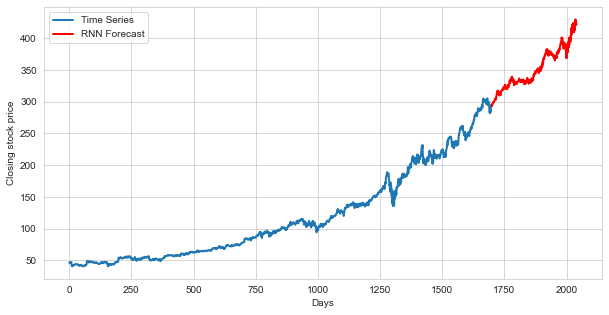

In [9]:
# Visualize.
figure = plt.figure(figsize=(10, 5))
plt.plot(data.values[:], linewidth=2)
off_s = len(data) - n_test + len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color="r", linewidth=2)

plt.ylabel("Closing stock price")
plt.xlabel("Days")

plt.legend(("Time Series", "RNN Forecast"), loc="best")
plt.show()

[0.0031828933861106634] [0.041475810110569]


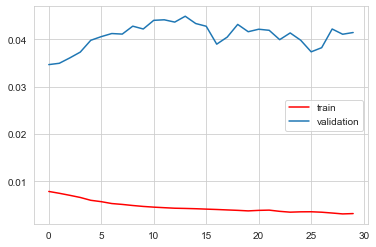

In [10]:
# Loss functions for val and train sets
plt.plot(history_loss, "r", label="train")
plt.plot(history_val_loss, label="validation")
plt.legend(loc="best")

print(history_loss[-1], history_val_loss[-1])

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            ARIMA Prediction Model
        </p>
    </a>
</blockquote>

Dickey-Fuller test: p=1.000000


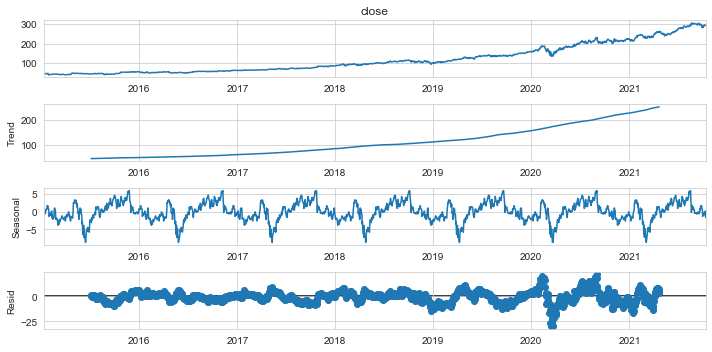

In [11]:
# Evaluate components of time-series.
# Evaluate Dickey-Fuller test for time-series stationarity.
plt.rc("figure", figsize=(10, 5))
data = pd.read_csv("microsoft_stocks.csv", index_col=["date"], parse_dates=["date"], encoding="cp1251")
sm.tsa.seasonal_decompose(data["close"], period=240).plot()

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data["close"])[1])

Best Box-Cox parameter: -0.265709
Dickey-Fuller test: p=0.964066


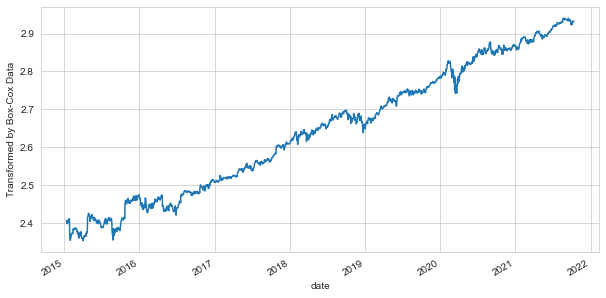

In [12]:
# Box-Cox transformation for dispersion stationarity.
plt.rc("figure", figsize=(10, 5))
data["close_box"], lmbda = st.boxcox(data["close"])
data["close_box"].plot()
plt.ylabel("Transformed by Box-Cox Data")

print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data["close_box"])[1])

Dickey-Fuller test: p=0.000000


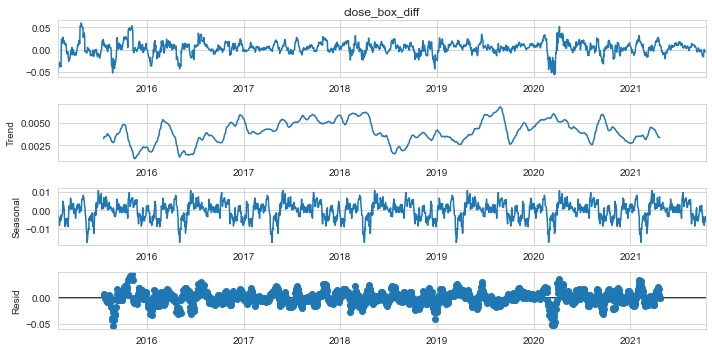

In [13]:
# Seasonal difference for 12 months.
plt.rc("figure", figsize=(10, 5))
data["close_box_diff"] = data["close_box"] - data["close_box"].shift(12)
sm.tsa.seasonal_decompose(data["close_box_diff"][12:], period=240).plot()

print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data["close_box_diff"][12:])[1])

Dickey-Fuller test: p=0.000000000000000


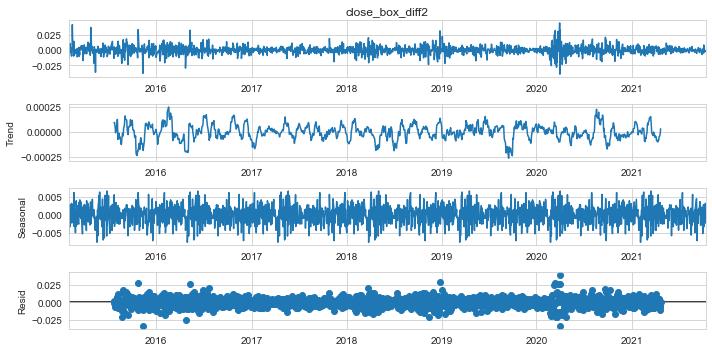

In [14]:
# Additional 1-step difference.
plt.rc("figure", figsize=(10, 5))
data["close_box_diff2"] = data["close_box_diff"] - data["close_box_diff"].shift(1)
sm.tsa.seasonal_decompose(data["close_box_diff2"][13:], period=240).plot()

print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(data["close_box_diff2"][13:])[1])

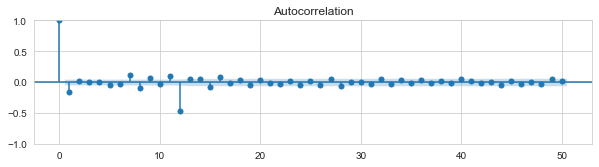

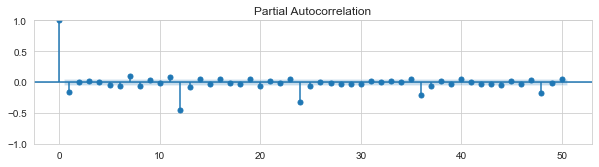

In [15]:
# Autocorrelation and partial autocorrelation components.
plt.rc("figure", figsize=(10, 5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data["close_box_diff2"][13:].values.squeeze(), lags=50, ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data["close_box_diff2"][13:].values.squeeze(), lags=50, ax=ax)
plt.show()

In [16]:
# Parameters for SARIMA model:
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use;
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use;
# d - show how many times have we derivated our series 1-step-wise;
# D - show how many times have we derivated our series Period-step-wise.
ps = range(0, 6)
d = 1
qs = range(0, 6)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [17]:
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(
            data["close_box"], order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    
    except ValueError:
        continue
    aic = model.aic
    
    model.predict()
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
result_table.sort_values(by="aic", ascending=True).head()

,parameters,aic
6,"(2, 5, 1, 0)",-12436.572890
5,"(1, 4, 1, 0)",-12425.301088
4,"(1, 0, 1, 0)",-12420.678936
3,"(0, 2, 1, 0)",-12418.440747
2,"(0, 1, 1, 0)",-12417.653557


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]

result_table.sort_values(by="aic", ascending=True).head()

,parameters,aic
6,"(2, 5, 1, 0)",-12436.572890
5,"(1, 4, 1, 0)",-12425.301088
4,"(1, 0, 1, 0)",-12420.678936
3,"(0, 2, 1, 0)",-12418.440747
2,"(0, 1, 1, 0)",-12417.653557


In [19]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                 1701
Model:             SARIMAX(2, 1, 5)x(1, 1, [], 12)   Log Likelihood                6227.286
Date:                             Mon, 03 Oct 2022   AIC                         -12436.573
Time:                                     12:11:25   BIC                         -12387.691
Sample:                                          0   HQIC                        -12418.470
                                            - 1701                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4854      0.456     -1.064      0.287      -1.380       0.409
ar.L2          0.4333      

Student test: p=0.802390
Dickey-Fuller test: p=0.0000000000000000000000005


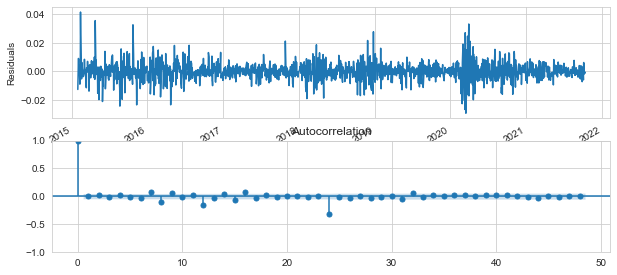

In [20]:
plt.rc("figure", figsize=(10, 5))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel("Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % st.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

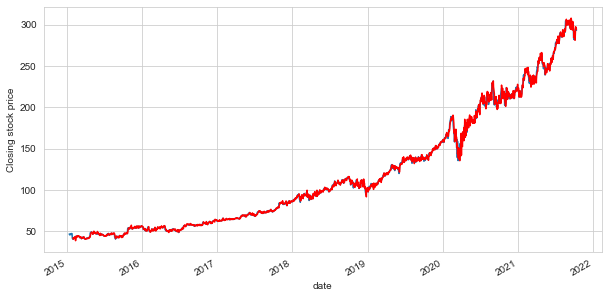

In [21]:
# Inverse Box-Cox transformation.
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

data["model"] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(10, 5))
data["close"].plot()
data["model"][13:].plot(color="r")
plt.ylabel("Closing stock price")
plt.show()

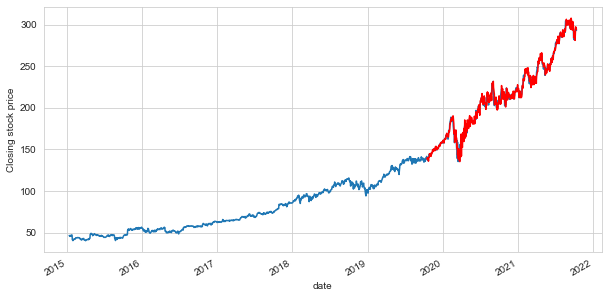

In [22]:
data2 = data[["close"]]
data2 = pd.concat([data2])
data2["forecast"] = invboxcox(best_model.predict(start=1200, end=1700), lmbda)

plt.figure(figsize=(10, 5))
data2["close"].plot()
data2["forecast"].plot(color="r")
plt.ylabel("Closing stock price")
plt.show()

In [26]:
mse = mean_squared_error(y_pred=data2["forecast"][-24:].tolist(), y_true=data2["close"][-24:].tolist())
r2 = r2_score(y_pred=data2["forecast"][-200:].tolist(), y_true=data2["close"][-200:].tolist())
mape = mean_absolute_percentage_error(y_pred=data2["forecast"][-200:].tolist(), y_true=data2["close"][-200:].tolist())

print("ARIMA Mean Squared Error:", mse)
print("ARIMA Mean Absolute Percentage Error:", mape)
print("ARIMA Coefficient of Determination:", r2)

ARIMA Mean Squared Error: 23.891088337593157
ARIMA Mean Absolute Percentage Error: 0.012875259339092589
ARIMA Coefficient of Determination: 0.9767338703032952


<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Conclusion
        </p>
    </a>
</blockquote>

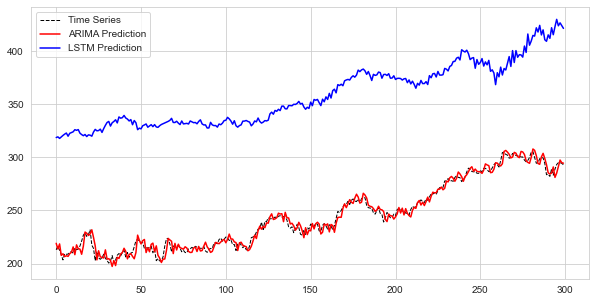

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(300), data2["close"][-300:], color="black", linewidth=1, linestyle='--', label="Time Series")
plt.plot(range(300), data2["forecast"][-300:], color="r", label="ARIMA Prediction")
plt.plot(range(300), yaxis[-300:], color="b", label="LSTM Prediction")
plt.legend(loc="best")
plt.show()

In the course of the practical task, multi-step LSTM and ARIMA predictive models were trained and applied in the Microsoft stock data forecasting task. The training results showed that the ARIMA model turned out to be more robust and learned to better approximate data. This follows the statistical learning metrics: 0.976 R-squared score for ARIMA versus -0.211 R-squared score for LSTM. It also follows from the visual analysis of the original time series and model predictions. The graph above shows that the ARIMA model has a smaller statistical error during the validation stage and reflects well the behavior of the series.